# Uncertainty analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


- We need to define the plume extent
- Idea:
    - Constant background
    - All points with value above the background considered as a plume.
    - False positive: background pixels considered part of cluster
    - False negative: plume pixels not considered in the cluster
    - Different types of high-valued areas
- Experiment on varying sparsity:
    - Different densities in different axis
    - How would that affect the results
- Experiment on missing data points
    - Add more missing points, what happens?
    - Add areas of missing points? Perlin noise?!
    

## Data

### Polynomial plume

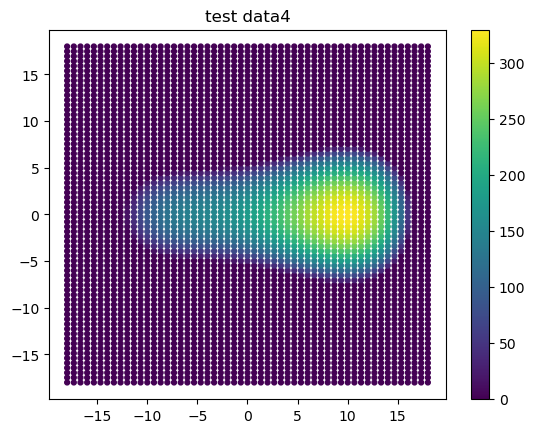

In [ ]:
def test4data(sigma):
    # Lets generate harder test points
    meshgrid = np.meshgrid(np.linspace(-18,18,55), np.linspace(-18,18,70))
    test4_lon = meshgrid[0].flatten()
    test4_lat = meshgrid[1].flatten()
    test4_no2 = -0.01*test4_lon**4 + 1.3*test4_lon**2 + 12*test4_lon + 100 - 6*test4_lat**2 + 80
    test4_no2[test4_no2<0] = 0
    test4_no2 = test4_no2 + np.random.normal(0,sigma,len(test4_no2))

    # Remove points in the shape of an ellipse
    #a,b = 1,15
    #centre = [7,-1] 
    #ellipse_equation = ((test4_lon-centre[0])**2/a**2 + (test4_lat-centre[1])**2/b**2)>1
    #test4_lon = test4_lon[ellipse_equation]
    #test4_lat = test4_lat[ellipse_equation]
    #test4_no2 = test4_no2[ellipse_equation]
    return test4_lon,test4_lat,test4_no2

x,y,values = test4data(0)

plt.scatter(x,y, c=values, s=12)
plt.title("test data4")
plt.colorbar()
plt.show()


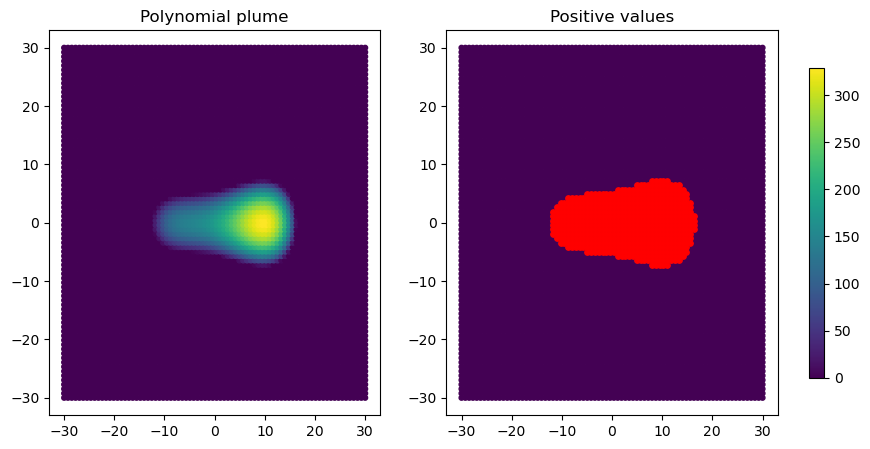

In [143]:
# Single image
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs = axs.flatten()

# Define the data
meshgrid = np.meshgrid(np.linspace(-30,30,80), np.linspace(-30,30,80))
x = meshgrid[0].flatten()
y = meshgrid[1].flatten()
values = -0.01*x**4 + 1.3*x**2 + 12*x + 100 - 6*y**2 + 80
values[values<0] = 0
#test4_no2 = test4_no2 + np.random.normal(0,sigma,len(test4_no2))


# 1st plot
sc = axs[0].scatter(x, y, c=values, s=12)
axs[0].set_title("Polynomial plume")

# 2nd plot
is_positive = values>0
axs[1].scatter(x,y, c=values, s=12)
axs[1].scatter(x[is_positive],y[is_positive], s=15, c='r')
axs[1].set_title("Positive values")

# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.show()


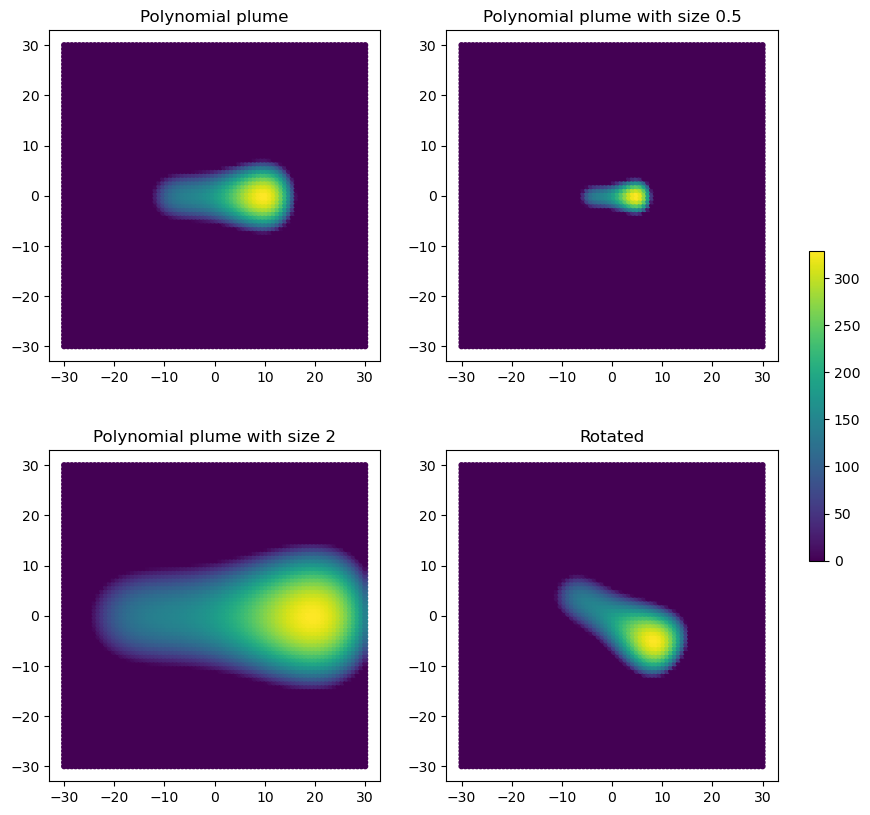

In [222]:
# Single image
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs = axs.flatten()

# Define the data
meshgrid = np.meshgrid(np.linspace(-30,30,80), np.linspace(-30,30,80))
x = meshgrid[0].flatten()
y = meshgrid[1].flatten()
size = 1
values = -0.01*(x*1/size)**4 + 1.3*(x*1/size)**2 + 12*(x*1/size) + 100 - 6*(y*1/size)**2 + 80
values[values<0] = 0
#test4_no2 = test4_no2 + np.random.normal(0,sigma,len(test4_no2))


# 1st plot
sc = axs[0].scatter(x, y, c=values, s=12)
axs[0].set_title("Polynomial plume")
axs[0].set_aspect('equal')


# 2nd plot
size = 0.5
values = -0.01*(x*1/size)**4 + 1.3*(x*1/size)**2 + 12*(x*1/size) + 100 - 6*(y*1/size)**2 + 80
values[values<0] = 0
axs[1].scatter(x,y, c=values, s=12)
axs[1].set_title(f"Polynomial plume with size {size}")
axs[1].set_aspect('equal')


# 3rd plot
size = 2
values = -0.01*(x*1/size)**4 + 1.3*(x*1/size)**2 + 12*(x*1/size) + 100 - 6*(y*1/size)**2 + 80
values[values<0] = 0
axs[2].scatter(x,y, c=values, s=12)
axs[2].set_title(f"Polynomial plume with size {size}")
axs[2].set_aspect('equal')

# 4th plot
size = 1
theta=np.pi/6
#x′=xcosθ−ysinθ
#y′=xsin⁡θ+ycos⁡θ
values = -0.01*((x*np.cos(theta)-y*np.sin(theta))*1/size)**4 + 1.3*((x*np.cos(theta)-y*np.sin(theta))*1/size)**2 + 12*((x*np.cos(theta)-y*np.sin(theta))*1/size) + 100 - 6*((x*np.sin(theta)+y*np.cos(theta))*1/size)**2 + 80
values[values<0] = 0
axs[3].scatter(x,y, c=values, s=12)
axs[3].set_title(f"Rotated")
axs[3].set_aspect('equal')


# Create a colorbar with its own axis
cbar = fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.show()




In [208]:
np.cos(np.pi/2)

6.123233995736766e-17

In [182]:
x=np.array([-1,10])
y=np.array([-1,0])

x*(np.cos(theta)-y*np.sin(theta)), (x*(np.sin(theta)+y*np.cos(theta)))

(array([-1.41421356,  7.07106781]), array([1.11022302e-16, 7.07106781e+00]))

### Advection–diffusion equation plume 

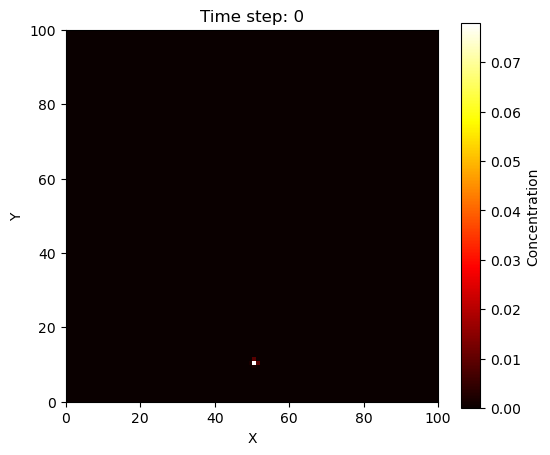

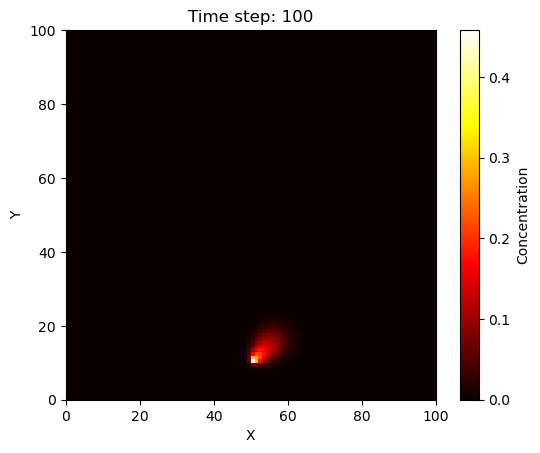

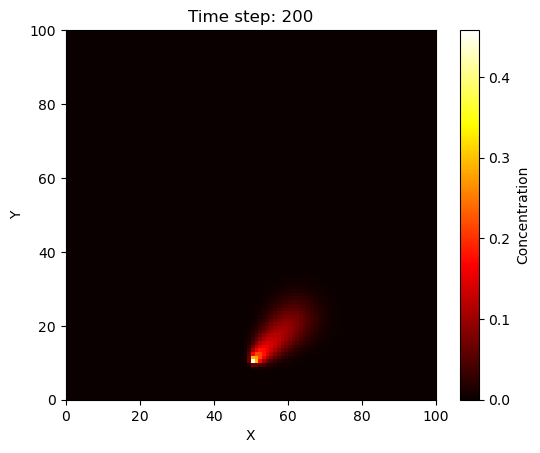

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_plume(num_steps=300,
                   plume_intensity=1.0,   # strength of the source (per time unit)
                   wind_speed=1.0,        # wind speed (grid units per time unit)
                   wind_direction=45,     # wind direction in degrees (0 = east, 90 = north)
                   diffusion_coefficient=0.2,  # dispersion/diffusion rate
                   source_location=(50, 10),   # (i, j) index of the source in the grid
                   grid_size=(100, 100),       # grid dimensions (nx, ny)
                   dx=1.0, dy=1.0,           # grid spacing in x and y
                   dt=0.1):                  # time step size

    nx, ny = grid_size
    # Initialize concentration field to zero
    C = np.zeros((nx, ny))
    
    # Convert wind direction from degrees to radians.
    # (Here, 0° means wind blowing to the right (east) and 90° upward (north))
    rad = np.deg2rad(wind_direction)
    u = wind_speed * np.cos(rad)  # x-component of wind
    v = wind_speed * np.sin(rad)  # y-component of wind

    # Set up the plot
    plt.figure(figsize=(6,5))
    
    for step in range(num_steps):
        # Inject the plume continuously at the source location.
        i_src, j_src = source_location
        C[i_src, j_src] += plume_intensity * dt
        
        # Create a new concentration array for the next time step.
        C_new = np.copy(C)
        
        # --- Compute updates on interior grid points ---
        # We update only the interior points (excluding boundaries).
        # For the advection terms, we use an upwind scheme:
        if u >= 0:
            dC_dx = (C[1:-1, 1:-1] - C[:-2, 1:-1]) / dx
        else:
            dC_dx = (C[2:, 1:-1] - C[1:-1, 1:-1]) / dx
            
        if v >= 0:
            dC_dy = (C[1:-1, 1:-1] - C[1:-1, :-2]) / dy
        else:
            dC_dy = (C[1:-1, 2:] - C[1:-1, 1:-1]) / dy
        
        # Diffusion (central differences)
        d2C_dx2 = (C[2:, 1:-1] - 2 * C[1:-1, 1:-1] + C[:-2, 1:-1]) / dx**2
        d2C_dy2 = (C[1:-1, 2:] - 2 * C[1:-1, 1:-1] + C[1:-1, :-2]) / dy**2
        
        # Update interior points with the advection-diffusion equation:
        #   ∂C/∂t + u ∂C/∂x + v ∂C/∂y = D (∂²C/∂x² + ∂²C/∂y²)
        C_new[1:-1, 1:-1] = C[1:-1, 1:-1] + dt * (
            - u * dC_dx - v * dC_dy + diffusion_coefficient * (d2C_dx2 + d2C_dy2)
        )
        
        # --- Apply boundary conditions (here: no-flux boundaries) ---
        # This simply copies the values from the nearest interior cell.
        C_new[0, :]   = C_new[1, :]
        C_new[-1, :]  = C_new[-2, :]
        C_new[:, 0]   = C_new[:, 1]
        C_new[:, -1]  = C_new[:, -2]
        
        # Update concentration field for next iteration.
        C = C_new
        
        # Plot every few time steps.
        if step % 100 == 0:
            plt.clf()
            plt.imshow(C.T, origin='lower', extent=[0, nx*dx, 0, ny*dy], cmap='hot')
            plt.title(f"Time step: {step}")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.colorbar(label='Concentration')
            plt.pause(0.05)
    
    plt.show()

# Run the simulation with the default parameters.
simulate_plume()


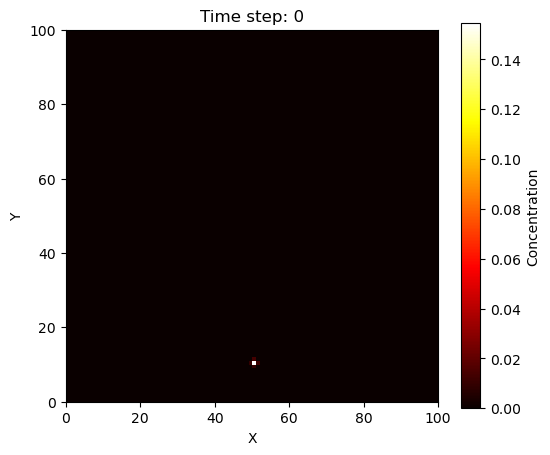

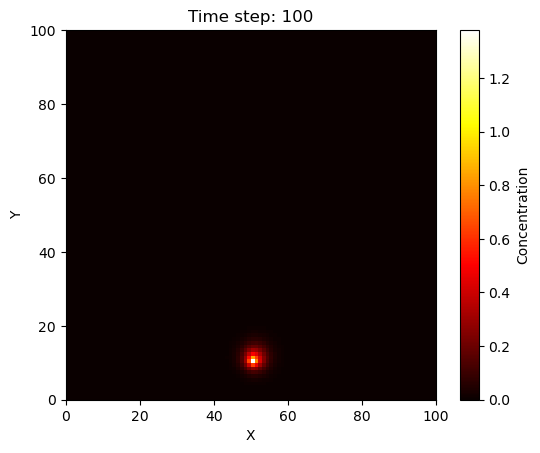

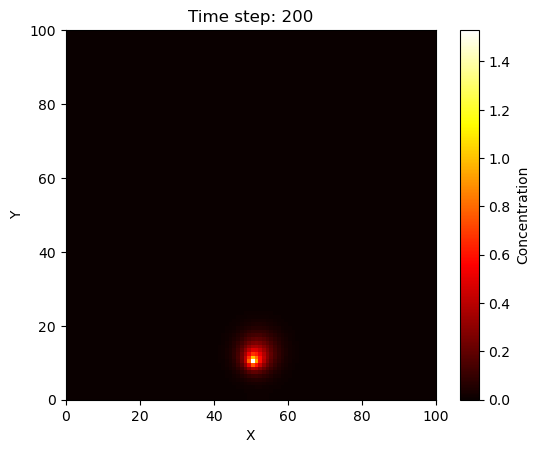

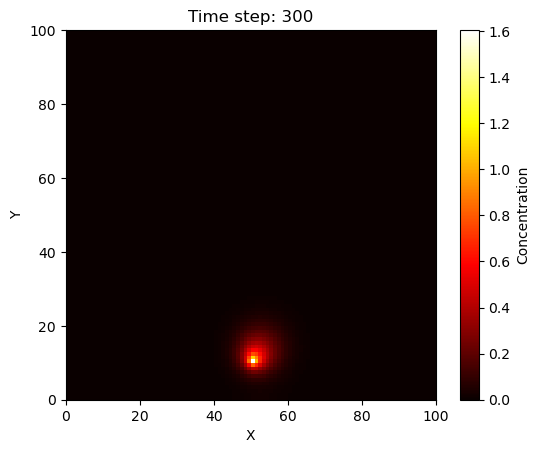

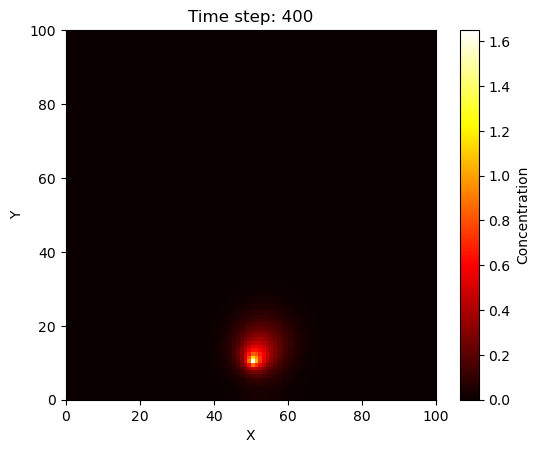

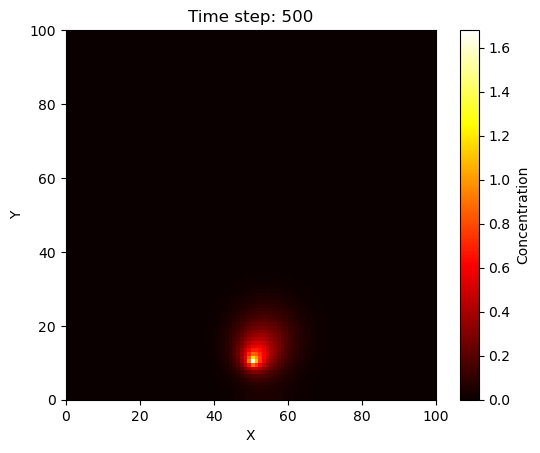

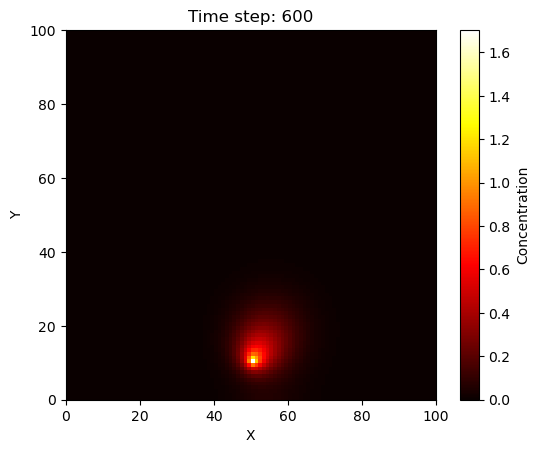

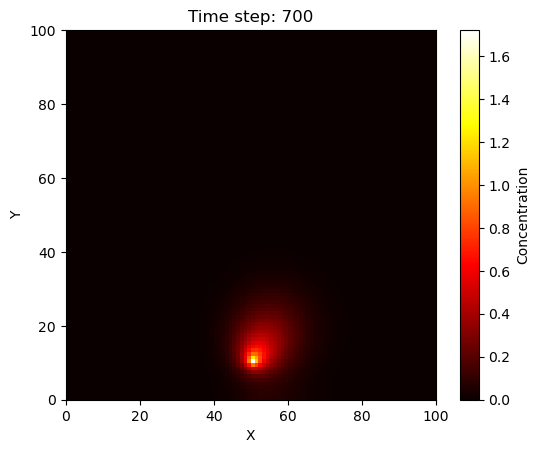

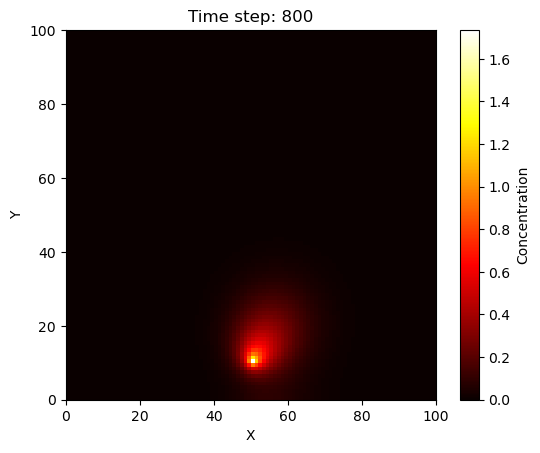

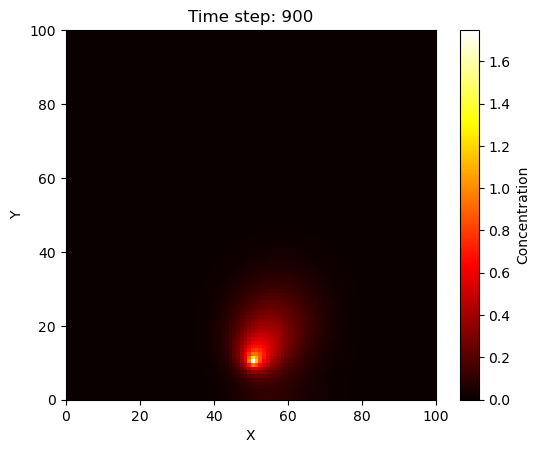

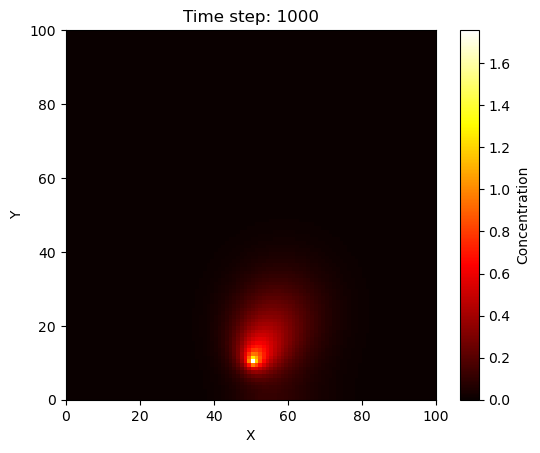

In [37]:
simulate_plume(num_steps=1001,
                   plume_intensity=2.0,   # strength of the source (per time unit)
                   wind_speed=0.2,        # wind speed (grid units per time unit)
                   wind_direction=60,     # wind direction in degrees (0 = east, 90 = north)
                   diffusion_coefficient=0.5,  # dispersion/diffusion rate
                   source_location=(50, 10),   # (i, j) index of the source in the grid
                   grid_size=(100, 100),       # grid dimensions (nx, ny)
                   dx=1.0, dy=1.0,           # grid spacing in x and y
                   dt=0.1)                 # time step size

### Triangles (sharp angles)

In [ ]:
def check_points_in_triangle_vectorized(points, v1, v2, v3):
    """
    Check if each point in the array `points` (shape: [n, 2])
    is inside the triangle defined by v1, v2, v3.
    
    Returns:
        A boolean NumPy array of shape (n,) where True means inside.
    """
    points = np.asarray(points)
    #v1 = np.asarray(v1)
    #v2 = np.asarray(v2)
    #v3 = np.asarray(v3)

    # Compute the "sign" values for each edge, for all points
    d1 = (points[:, 0] - v2[0]) * (v1[1] - v2[1]) - (v1[0] - v2[0]) * (points[:, 1] - v2[1])
    d2 = (points[:, 0] - v3[0]) * (v2[1] - v3[1]) - (v2[0] - v3[0]) * (points[:, 1] - v3[1])
    d3 = (points[:, 0] - v1[0]) * (v3[1] - v1[1]) - (v3[0] - v1[0]) * (points[:, 1] - v1[1])
    
    # A point is inside if it is on the same side of all three edges.
    inside = ((d1 >= 0) & (d2 >= 0) & (d3 >= 0)) | ((d1 <= 0) & (d2 <= 0) & (d3 <= 0))
    return inside

# Example usage:
triangle = ((1, 2), (4, 8), (7, 2))
points = np.array([[4, 4], [8, 8], [3, 3], [2, 2]])
results = check_points_in_triangle_vectorized(points, *triangle)

for pt, inside in zip(points, results):
    status = "inside" if inside else "outside"
    print(f"Point {pt} is {status} the triangle.")


Point [4 4] is inside the triangle.
Point [8 8] is outside the triangle.
Point [3 3] is inside the triangle.
Point [2 2] is inside the triangle.


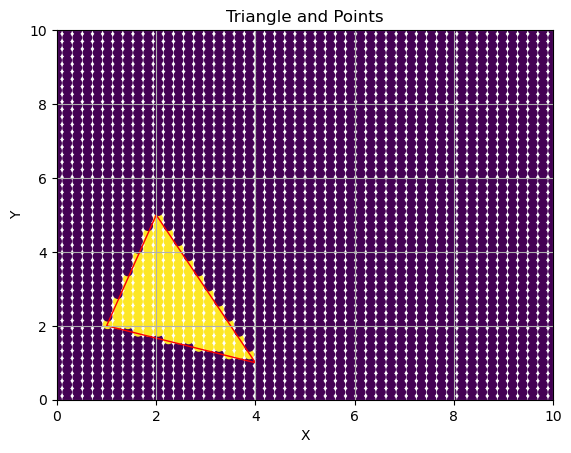

In [107]:
# Define the triangle vertices and points
triangle = ((2, 5), (4, 1), (1, 2))

points = np.array([[4, 4], [8, 8], [3, 3], [2, 2]])
meshgrid = np.meshgrid(np.linspace(0,10,50), np.linspace(0,10,50))
points = np.array(meshgrid).reshape(2,-1).T

results = check_points_in_triangle_vectorized(points, *triangle)

# Create a plot
fig, ax = plt.subplots()

# Plot the points
ax.scatter(points[:, 0], points[:, 1], c=results.astype(int))  # 'bo' means blue color, circle markers

# Set plot limits
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

# Plot the triangle
triangle_patch = Polygon(triangle, closed=True, fill=None, edgecolor='r')
ax.add_patch(triangle_patch)

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Triangle and Points')

# Show the plot
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'test data5')

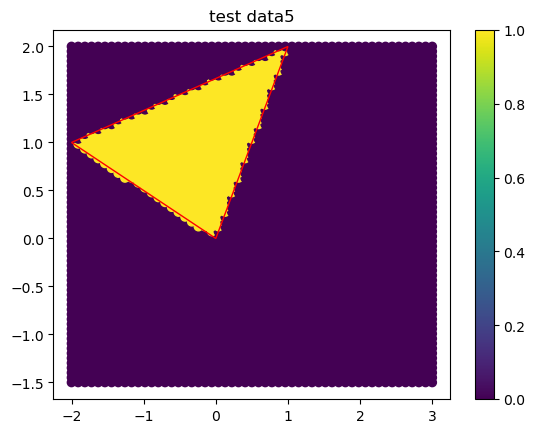

In [109]:
meshgrid = np.meshgrid(np.linspace(-2,3,55), np.linspace(-1.5,2,70))
points = np.array(meshgrid).reshape(2,-1).T

triangle = ((0, 0), (1, 2), (-2, 1))

results = check_points_in_triangle_vectorized(points, *triangle)

# Create a plot
fig, ax = plt.subplots()

plt.scatter(points[:,0],points[:,1], c=results)

# Plot the triangle
triangle_patch = Polygon(triangle, closed=True, fill=None, edgecolor='r')
ax.add_patch(triangle_patch)

plt.colorbar()
plt.title("test data5")

In [86]:
results

array([False, False, False, ..., False, False, False])